#**1.환경설정**

In [3]:
import sys
import platform
import os
import datetime
import pytz
timezone = pytz.timezone("Asia/Seoul")
import random

import shutil

import tensorflow.keras
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np

import cv2

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print()
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
print(f"Open CV {cv2.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


def working_dir_clean():
    list_all_file=os.listdir("./")
    for file_name in list_all_file:
        try:
            shutil.rmtree("./"+file_name)
            print(f"Remove File Name : {file_name}")
        
        except Exception as e:
            print('Exception:',e)
                    #if any exception rasied, the exception will be printed here. And pass to the next image
        
working_dir_clean()

Python Platform: Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

Tensor Flow Version: 2.9.2
Keras Version: 2.9.0
Pandas 1.3.5
Scikit-Learn 1.0.2
Numpy 1.21.6
Open CV 4.6.0

GPU is available
Remove File Name : .config
Remove File Name : sample_data


#**2.데이터**
 
[COVID-19 Radiography Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)

4개의 Class로 구성 


*   COVID
*   Normal
*   Lung Opacity
*   Viral Pneumonia

총 2999개의 이미지 (COVID: 874개, Non-COVID : 2125개)




In [8]:
#구글 드라이브 연동 
from google.colab import drive
drive.mount('/content/drive')   


Mounted at /content/drive


In [9]:
#구글 드라이브 내의 압축파일 해제 
!unzip -qq "/content/drive/MyDrive/Data/X-ray.zip"


In [10]:
!unzip -qq "/content/drive/MyDrive/Data/Curated Chest X-Ray Image Dataset for COVID-19.zip"

In [4]:
#카테고리 설정 

categories=["양성","음성"]

labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'양성': 0, '음성': 1}
['양성', '음성']
[0, 1]


In [61]:
# 양성 경로 설정 
folder_path_covid =["./COVID", 
                    "./Curated X-Ray Dataset/COVID-19"]

def file_add_to_array(folder_path,append_array):
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        append_array.append(img_path)
    

img_path_covid_old =[]
for folder_path in folder_path_covid:
    file_add_to_array(folder_path,img_path_covid_old)


# 음성 경로 설정 
folder_path_non_covid =[
    "./Lung opacity",
    "./Normal",
    "./Viral Pneumonia",
    "./Curated X-Ray Dataset/Normal",
    "./Curated X-Ray Dataset/Pneumonia-Bacterial",
    "./Curated X-Ray Dataset/Pneumonia-Viral"

]


img_path_non_covid_old =[]
for folder_path in folder_path_non_covid:
    file_add_to_array(folder_path,img_path_non_covid_old)
    

covid_images_on_data_set = len(img_path_covid_old)
covid_non_images_on_data_set = len(img_path_non_covid_old)
Total_images_on_data_set = covid_images_on_data_set + covid_non_images_on_data_set

print(f" Total Images on the data set : {Total_images_on_data_set}\n Covid Images : {covid_images_on_data_set}\n Non Covid Images : {Total_images_on_data_set}\n")    
        
# 셔플 
img_path_covid_old = random.sample(img_path_covid_old, len(img_path_covid_old))
img_path_non_covid_old = random.sample(img_path_non_covid_old, len(img_path_non_covid_old))

        

divider = 10
middle_img_path_covid = int(len(img_path_covid_old)/divider)
middle_img_path_non_covid = int(len(img_path_non_covid_old)/divider)

img_path_covid =img_path_covid_old[:middle_img_path_covid]
img_path_non_covid =img_path_non_covid_old[:middle_img_path_non_covid]

total_images = len(img_path_non_covid) + len(img_path_covid)

#데이터 셋 개수 출력 

print(f"양성 이미지 수     : {len(img_path_covid)}")           
print(f"음성 이미지 수     : {len(img_path_non_covid)}")   
print(f"전체 이미지 수     : {total_images}") 
print(f"양성               : {round((len(img_path_covid)/total_images)*100, 2)} %")           
print(f"음성               : {round((len(img_path_non_covid)/total_images)*100, 2)} %")     
        

 Total Images on the data set : 39206
 Covid Images : 10026
 Non Covid Images : 39206

양성 이미지 수     : 1002
음성 이미지 수     : 2918
전체 이미지 수     : 3920
양성               : 25.56 %
음성               : 74.44 %


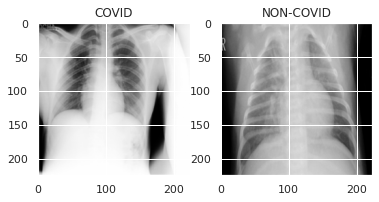

In [62]:
import matplotlib.image as img
image_covid = img.imread(img_path_covid_old[0])
image_non_covid = img.imread(img_path_non_covid[0])

plt.figure(figsize=(6,8))
plt.subplot(1, 2, 1)   

plt.title('COVID')
plt.imshow(image_covid)

plt.subplot(1, 2, 2)
 
plt.title('NON-COVID')
plt.imshow(image_non_covid)
plt.show()


In [63]:
start_time = datetime.datetime.now(tz=timezone)
print(f"시작 :{start_time}")
img_size=224
data=[]
target=[]

def image_add(img_path,category) :
    img=cv2.imread(img_path)
    try:
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
                    #gray scale로 변환 
        resized=cv2.resize(gray,(img_size,img_size))
                    #224x224로 변환 
        data.append(resized)
        target.append(label_dict[category])
                    #이미지에 라벨링 

    except Exception as e:
        print('Exception:',e)
                    #Exception 발생 시 출력 

for category in categories:
    if(category == "양성"):
        for img_path in img_path_covid:
            image_add(img_path,category)  
    else:
        for img_path in img_path_non_covid:
            image_add(img_path,category)  

                    
end_time =datetime.datetime.now(tz=timezone)                  
print(f"종료 :{end_time}")

print(f"소요시간 : {end_time-start_time}")

시작 :2022-11-19 02:21:36.874588+09:00
종료 :2022-11-19 02:22:00.529715+09:00
소요시간 : 0:00:23.655127


In [64]:
#이미지 전처리 1/255 

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


new_target=tf.keras.utils.to_categorical(target)


print(f"Data shape : {data.shape} \nTarget shape : {target.shape} \nNew Target shape : {new_target.shape}")

Data shape : (3920, 224, 224, 1) 
Target shape : (3920,) 
New Target shape : (3920, 2)


In [66]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint


input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7,9]

for k in range(len(parrallel_kernels)):
    if(k !=0):
        conv = Conv2D(128, kernel_size = k,padding = 'same' ,activation='relu')(inp)

        convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp, out)

model = Sequential()
model.add(conv_model)

# Hidden Layer 1
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden Layer 2
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden Layer 3
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Output layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 224, 224, 384)     2176      
                                                                 
 conv2d_9 (Conv2D)           (None, 222, 222, 128)     442496    
                                                                 
 activation_3 (Activation)   (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 128)    0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 activation_4 (Activation)   (None, 109, 109, 64)      0         
                                                      

In [67]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.3)

print(type (train_data))
print(f"Training Data shape : {train_data.shape} \nTraining Target shape : {train_target.shape}")
print(f"Test Data shape : {test_data.shape} \nTest Target shape : {test_target.shape}")

<class 'numpy.ndarray'>
Training Data shape : (2744, 224, 224, 1) 
Training Target shape : (2744,)
Test Data shape : (1176, 224, 224, 1) 
Test Target shape : (1176,)


In [70]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#과적합 문제가 발생하여 적당한 epoch에서 stop
#ModelCheckpoint instance를 callbacks 파라미터에 넣어줌으로써, 가장 validation performance 가 좋았던 모델을 저장

In [78]:
start_time = datetime.datetime.now(tz=timezone)
print(f"시작:{start_time}")

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')


history=model.fit(train_data,
                  train_target,
                  epochs=50,
                  callbacks=[checkpoint,es,mc],
                  validation_split=0.1)
end_time = datetime.datetime.now(tz=timezone)


print(f"종료 시간:{end_time}")
print(f"총 소요시간 {end_time-start_time}")

시작:2022-11-19 02:35:35.432302+09:00


NameError: ignored

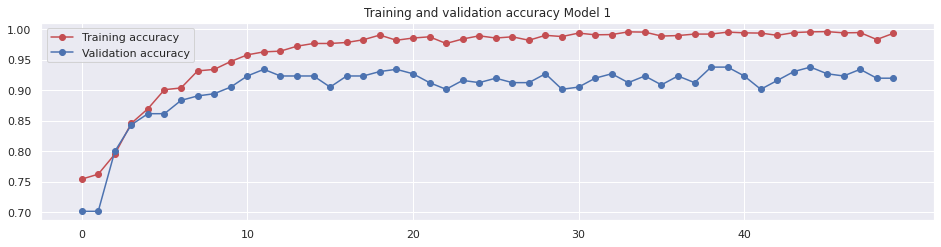

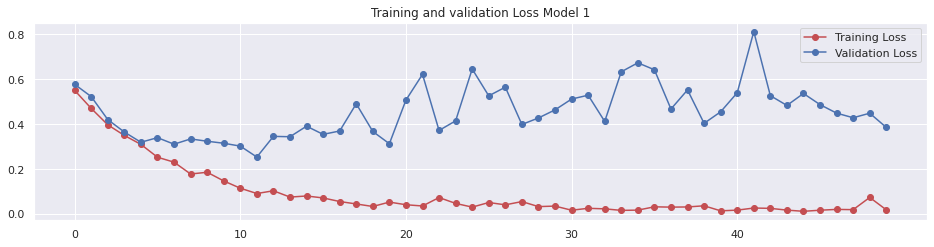

<Figure size 432x288 with 0 Axes>

In [79]:
# 시각화 

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(acc))

fig = plt.gcf()
plt.subplot(2,1,1)
fig.set_size_inches(16, 8)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy Model 1')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()


fig = plt.gcf()
plt.subplot(2,1,2)
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss Model 1')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

In [73]:
print(model.evaluate(test_data,test_target))

37/37 [==============================] - 2s 40ms/step - loss: 0.4052 - accuracy: 0.9209
[0.4052466154098511, 0.920918345451355]


In [ ]:
model.save('model.h5')

In [85]:
#위에서 callback을 통해 loss가 가장 작았던 모델을 best model에 저장 
best_model = tf.keras.models.load_model('best_model.h5')
print(best_model.evaluate(test_data,test_target))

37/37 [==============================] - 2s 40ms/step - loss: 0.3231 - accuracy: 0.9082
[0.32307448983192444, 0.9081632494926453]
